Dataset
=========================================
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com.


Dataset characteristics
=========================================
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit :
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registere

# Importing Libraries and Dataset

In [ ]:
!pip install prophet
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [ ]:
# Connecting Google Drive to load/store datset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing datasets
day = pd.read_csv('/content/drive/MyDrive/day.csv')
hour = pd.read_csv('/content/drive/MyDrive/hour.csv')

# Pre-Processing

In [ ]:
# Dropping NaN values
day = day.dropna()
hour = hour.dropna()

# DataFrame after dropping NaNs
print("\nDay DataFrame after dropping NaNs:")
print(day.shape)

print("\nHour DataFrame after dropping NaNs:")
print(hour.shape)


Day DataFrame after dropping NaNs:
(731, 16)

Hour DataFrame after dropping NaNs:
(17379, 17)


In [ ]:
# Ensuring date/time data is in correct format
day['dteday'] = pd.to_datetime(day['dteday'])
hour['dteday'] = pd.to_datetime(hour['dteday'])

In [ ]:
# dropping irrelevant columns
# Dropping dteday since these are captured in derived features
day = day.drop(columns=['instant', 'dteday'])
hour = hour.drop(columns=['instant', 'dteday'])

In [ ]:
# X and y
# 1. Regression for cnt
# 2. Regression for casual
# 3. Regression for registered

# 1.
X1_day = day.drop(columns=['casual', 'registered', 'cnt'])
X1_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y1_day = day['cnt']
y1_hour = hour['cnt']

# 2.
X2_day = day.drop(columns=['casual', 'registered', 'cnt'])
X2_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y2_day = day['casual']
y2_hour = hour['casual']

# 3.
X3_day = day.drop(columns=['casual', 'registered', 'cnt'])
X3_hour = hour.drop(columns=['casual', 'registered', 'cnt'])

y3_day = day['registered']
y3_hour = hour['registered']

In [ ]:
# Splitting data
# 1. Regression for cnt
X1_train_day, X1_test_day, y1_train_day, y1_test_day = train_test_split(X1_day, y1_day, test_size=0.20, random_state=42)
X1_train_hour, X1_test_hour, y1_train_hour, y1_test_hour = train_test_split(X1_hour, y1_hour, test_size=0.20, random_state=42)

# 2. Regression for casual
X2_train_day, X2_test_day, y2_train_day, y2_test_day = train_test_split(X2_day, y2_day, test_size=0.20, random_state=42)
X2_train_hour, X2_test_hour, y2_train_hour, y2_test_hour = train_test_split(X2_hour, y2_hour, test_size=0.20, random_state=42)

# 3. Regression for registered
X3_train_day, X3_test_day, y3_train_day, y3_test_day = train_test_split(X3_day, y3_day, test_size=0.20, random_state=42)
X3_train_hour, X3_test_hour, y3_train_hour, y3_test_hour = train_test_split(X3_hour, y3_hour, test_size=0.20, random_state=42)

# Random Forest Regressor Ensemble

With GridSearchCV:

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_params(x_train, y_train):
  # Define the parameter grid
  param_grid = {
      'max_depth': [1, 2, 3, 4],
      'n_estimators': [100, 300, 500],
      'min_samples_split': [2, 6, 10],
      'max_features': [0.2, 0.4, 0.6, 0.8, 1]
  }

  # Initialize the XGBoost Regressor
  RF_reg = RandomForestRegressor()

  # Set up GridSearchCV
  grid_search = GridSearchCV(estimator=RF_reg, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=3, verbose=1, n_jobs=-1)

  # Fit GridSearchCV
  grid_search.fit(x_train, y_train)
  return grid_search

# params = get_params(X3_train_day, y3_train_day)

In [ ]:

# from sklearn.metrics import accuracy_score
def RF_eval(X_train, y_train, X_test, y_test):
  #initialize model
  model = get_params(X_train, y_train)

  # Predicting on the test set
  y_pred = model.predict(X_test)

  # Evaluate the performance
  rmse = mean_squared_error(y_test, y_pred, squared=False) # false to return RMSE instead of MSE
  r2 = r2_score(y_test, y_pred)

  return rmse, r2


RMSEs = []
r2s = []

# total count day
mse1_train_day, r2_1_train_day = RF_eval(X1_train_day, y1_train_day, X1_test_day, y1_test_day)
RMSEs.append(mse1_train_day)
r2s.append(r2_1_train_day)
print(f"RMSE #1 (total count) for day: {mse1_train_day:.2f}")
print(f"R^2 Score #1 (total count) for day: {r2_1_train_day:.2f}")

# total count hour
mse1_train_hour, r2_1_train_hour = RF_eval(X1_train_hour, y1_train_hour, X1_test_hour, y1_test_hour)
RMSEs.append(mse1_train_hour)
r2s.append(r2_1_train_hour)
print(f"RMSE #1 (total count) for hour: {mse1_train_hour:.2f}")
print(f"R^2 Score #1 (total count) for hour: {r2_1_train_hour:.2f}")

# total casual day
mse2_train_day, r2_2_train_day = RF_eval(X2_train_day, y2_train_day, X2_test_day, y2_test_day)
RMSEs.append(mse2_train_day)
r2s.append(r2_2_train_day)
print(f"RMSE #2 (total casual) for day: {mse2_train_day:.2f}")
print(f"R^2 Score #2 (total casual) for day: {r2_2_train_day:.2f}")

# total casual hour
mse2_train_hour, r2_2_train_hour = RF_eval(X2_train_hour, y2_train_hour, X2_test_hour, y2_test_hour)
RMSEs.append(mse2_train_hour)
r2s.append(r2_2_train_hour)
print(f"RMSE #2 (total casual) for hour: {mse2_train_hour:.2f}")
print(f"R^2 Score #2 (total casual) for hour: {r2_2_train_hour:.2f}")

# total registered day
mse3_train_day, r2_3_train_day = RF_eval(X3_train_day, y3_train_day, X3_test_day, y3_test_day)
RMSEs.append(mse3_train_day)
r2s.append(r2_3_train_day)
print(f"RMSE #3 (total registered) for day: {mse3_train_day:.2f}")
print(f"R^2 Score #3 (total registered) for day: {r2_3_train_day:.2f}")

# total registered hour
mse3_train_hour, r2_3_train_hour = RF_eval(X3_train_hour, y3_train_hour, X3_test_hour, y3_test_hour)
RMSEs.append(mse3_train_hour)
r2s.append(r2_3_train_hour)
print(f"RMSE #3 (total registered) for hour: {mse3_train_hour:.2f}")
print(f"R^2 Score #3 (total registered) for hour: {r2_3_train_hour:.2f}")

Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #1 (total count) for day: 852.71
R^2 Score #1 (total count) for day: 0.82
Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #1 (total count) for hour: 112.77
R^2 Score #1 (total count) for hour: 0.60
Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #2 (total casual) for day: 287.69
R^2 Score #2 (total casual) for day: 0.79
Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #2 (total casual) for hour: 26.13
R^2 Score #2 (total casual) for hour: 0.70
Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #3 (total registered) for day: 755.72
R^2 Score #3 (total registered) for day: 0.79
Fitting 3 folds for each of 180 candidates, totalling 540 fits
RMSE #3 (total registered) for hour: 100.29
R^2 Score #3 (total registered) for hour: 0.54


Without GridSearchCV

In [ ]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor()

MSEs = []
r2s = []

# train day total cnt
mse_1_day = -cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model.fit(X1_train_day, y1_train_day)
y1_pred = model.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour total cnt
mse_1_hour = -cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model.fit(X1_train_hour, y1_train_hour)
y1_pred = model.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train day casual
mse_2_day = -cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model.fit(X2_train_day, y2_train_day)
y2_pred = model.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour casual
mse_2_hour = -cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model.fit(X2_train_hour, y2_train_hour)
y2_pred = model.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train day registered
mse_3_day = -cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model.fit(X3_train_day, y3_train_day)
y3_pred = model.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

# train hour registered
mse_3_hour = -cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model.fit(X3_train_hour, y3_train_hour)
y3_pred = model.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs.append(test_mse)
r2s.append(test_r2)
print('\n')

Average MSE for #1 (total count) for "day" df: 783.1036091388861
Average R2 for #1 (total count) for "day" df: 0.8163437443532517


Test MSE for #1 (total count) for "day" df: 452486.85417278914
Test R2 for #1 (total count) for "day" df: 0.8871570730489857


Average MSE for #1 (total count) for "hour" df: 50.77326322690458
Average R2 for #1 (total count) for "hour" df: 0.9221549825750202


Test MSE for #1 (total count) for "hour" df: 1770.5243179342397
Test R2 for #1 (total count) for "hour" df: 0.9440864892256803


Average MSE for #2 (casuals only) for "day" df: 783.1036091388861
Average R2 for #2 (casuals only) for "day" df: 0.7521524839694476


Test MSE for #2 (casuals only) for "day" df: 72038.74680068027
Test R2 for #2 (casuals only) for "day" df: 0.8150972513338108


Average MSE for #2 (casuals only) for "hour" df: 16.519830018361006
Average R2 for #2 (casuals only) for "hour" df: 0.8864033886142699


Test MSE for #2 (casuals only) for "hour" df: 192.51194440389443
Test R2 for #2

Graphing:

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

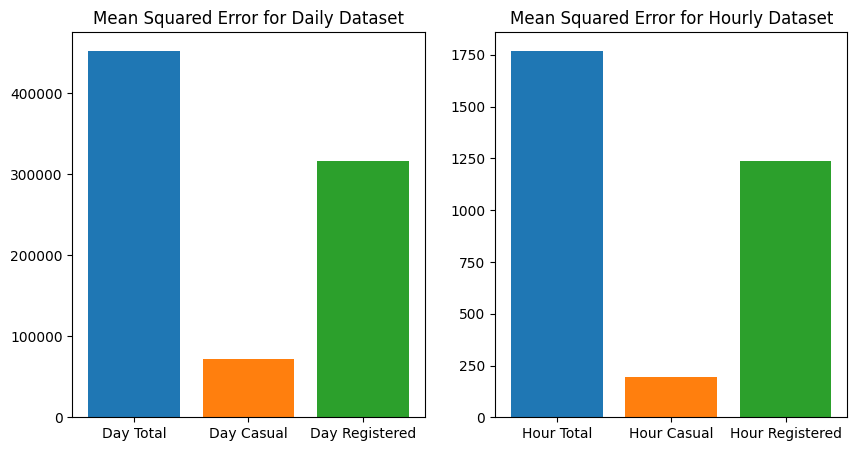

In [ ]:

labels = ['Day Total', 'Hour Total',
          'Day Casual', 'Hour Casual',
          'Day Registered', 'Hour Registered']
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, MSEs):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')



Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

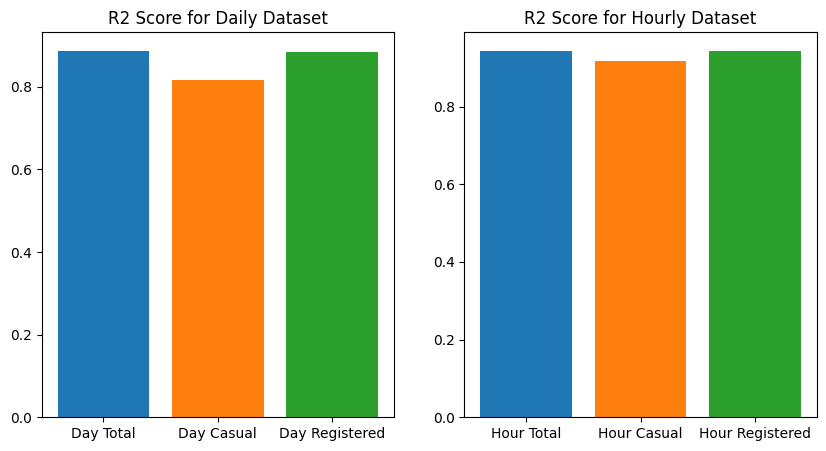

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j in zip(labels, r2s):
  if 'Day' in i:
    ax1.bar(i, j)
  else:
    ax2.bar(i, j)

ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')



(3476,)
(3476,)


Text(0.5, 1.0, 'Actual vs Predicted for Hourly Registered Dataset')

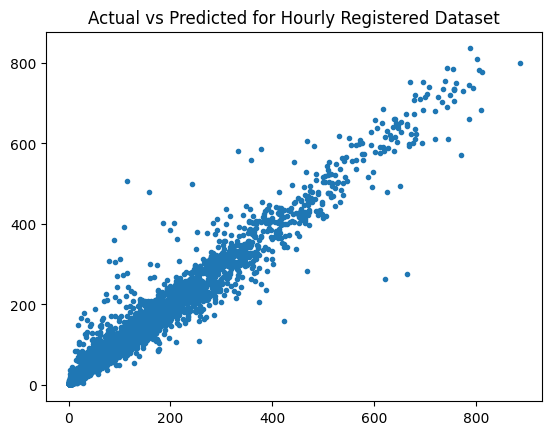

In [ ]:
# graphical output for last model Hourly Registered
print(y3_pred.shape)
print(y3_test_hour.shape)
plt.plot(y3_test_hour, y3_pred, '.')
plt.title('Actual vs Predicted for Hourly Registered Dataset')
# plt.plot(y3_test_hour, '.')

# RF Regression with PCA

In [ ]:
from sklearn.decomposition import PCA
pca_day = PCA(n_components=2)  # Adjust n_components as needed
pca_day_result = pca_day.fit_transform(day)

# Explained variance ratio
print("Explained Variance Ratio:", pca_day.explained_variance_ratio_)
print("Features:", pca_day.get_feature_names_out())

pca_hour = PCA(n_components=2)  # Adjust n_components as needed
pca_hour_result = pca_hour.fit_transform(hour)

# Explained variance ratio
print("Explained Variance Ratio:", pca_hour.explained_variance_ratio_)
print("Features:", pca_hour.get_feature_names_out)
pca_day.get_feature_names_out()

Explained Variance Ratio: [0.92950567 0.07049185]
Features: ['pca0' 'pca1']
Explained Variance Ratio: [0.96098056 0.03802317]
Features: <bound method ClassNamePrefixFeaturesOutMixin.get_feature_names_out of PCA(n_components=2)>


array(['pca0', 'pca1'], dtype=object)

In [ ]:
# Reconstruct data using the first two principal components
reconstructed_data = pca_day.inverse_transform(pca_day_result)
reconstructed_day = pd.DataFrame(reconstructed_data, columns=day.columns, index=day.index)

In [ ]:
# Reconstruct data using the first two principal components
reconstructed_data_hour = pca_hour.inverse_transform(pca_hour_result)
reconstructed_hour = pd.DataFrame(reconstructed_data_hour, columns=hour.columns, index=hour.index)

In [ ]:
# X and y
# 1. for cnt
# 2. for casual
# 3. for registered

# 1.
X1_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X1_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y1_day = reconstructed_day['cnt']
y1_hour = reconstructed_hour['cnt']

# 2.
X2_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X2_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y2_day = reconstructed_day['casual']
y2_hour = reconstructed_hour['casual']

# 3.
X3_day = reconstructed_day.drop(columns=['casual', 'registered', 'cnt'])
X3_hour = reconstructed_hour.drop(columns=['casual', 'registered', 'cnt'])

y3_day = reconstructed_day['registered']
y3_hour = reconstructed_hour['registered']

In [ ]:
# Splitting data
# 1. for cnt
X1_train_day, X1_test_day, y1_train_day, y1_test_day = train_test_split(X1_day, y1_day, test_size=0.20, random_state=42)
X1_train_hour, X1_test_hour, y1_train_hour, y1_test_hour = train_test_split(X1_hour, y1_hour, test_size=0.20, random_state=42)

# 2. for casual
X2_train_day, X2_test_day, y2_train_day, y2_test_day = train_test_split(X2_day, y2_day, test_size=0.20, random_state=42)
X2_train_hour, X2_test_hour, y2_train_hour, y2_test_hour = train_test_split(X2_hour, y2_hour, test_size=0.20, random_state=42)

# 3. for registered
X3_train_day, X3_test_day, y3_train_day, y3_test_day = train_test_split(X3_day, y3_day, test_size=0.20, random_state=42)
X3_train_hour, X3_test_hour, y3_train_hour, y3_test_hour = train_test_split(X3_hour, y3_hour, test_size=0.20, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

def get_params(x_train, y_train):
  # Define the parameter grid
  param_grid = {
      'max_depth': [1, 2, 3, 4],
      # 'n_estimators': [100, 300, 500],
      'min_samples_split': [2, 6, 10],
      'max_features': [0.2, 0.4, 0.6, 0.8, 1]
  }

  # Initialize the XGBoost Regressor
  RF_reg = RandomForestRegressor()

  # Set up GridSearchCV
  grid_search = GridSearchCV(estimator=RF_reg, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=3, verbose=1, n_jobs=-1)

  # Fit GridSearchCV
  grid_search.fit(x_train, y_train)
  return grid_search

# params = get_params(X3_train_day, y3_train_day)

In [ ]:

# from sklearn.metrics import accuracy_score
def RF_eval(X_train, y_train, X_test, y_test):
  #initialize model
  model = get_params(X_train, y_train)

  # Predicting on the test set
  y_pred = model.predict(X_test)

  # Evaluate the performance
  rmse = mean_squared_error(y_test, y_pred, squared=False) # false to return RMSE instead of MSE
  r2 = r2_score(y_test, y_pred)

  return rmse, r2


RMSEs = []
r2s = []

# total count day
mse1_train_day, r2_1_train_day = RF_eval(X1_train_day, y1_train_day, X1_test_day, y1_test_day)
RMSEs.append(mse1_train_day)
r2s.append(r2_1_train_day)
print(f"RMSE #1 (total count) for day: {mse1_train_day:.2f}")
print(f"R^2 Score #1 (total count) for day: {r2_1_train_day:.2f}")

# total count hour
mse1_train_hour, r2_1_train_hour = RF_eval(X1_train_hour, y1_train_hour, X1_test_hour, y1_test_hour)
RMSEs.append(mse1_train_hour)
r2s.append(r2_1_train_hour)
print(f"RMSE #1 (total count) for hour: {mse1_train_hour:.2f}")
print(f"R^2 Score #1 (total count) for hour: {r2_1_train_hour:.2f}")

# total casual day
mse2_train_day, r2_2_train_day = RF_eval(X2_train_day, y2_train_day, X2_test_day, y2_test_day)
RMSEs.append(mse2_train_day)
r2s.append(r2_2_train_day)
print(f"RMSE #2 (total casual) for day: {mse2_train_day:.2f}")
print(f"R^2 Score #2 (total casual) for day: {r2_2_train_day:.2f}")

# total casual hour
mse2_train_hour, r2_2_train_hour = RF_eval(X2_train_hour, y2_train_hour, X2_test_hour, y2_test_hour)
RMSEs.append(mse2_train_hour)
r2s.append(r2_2_train_hour)
print(f"RMSE #2 (total casual) for hour: {mse2_train_hour:.2f}")
print(f"R^2 Score #2 (total casual) for hour: {r2_2_train_hour:.2f}")

# total registered day
mse3_train_day, r2_3_train_day = RF_eval(X3_train_day, y3_train_day, X3_test_day, y3_test_day)
RMSEs.append(mse3_train_day)
r2s.append(r2_3_train_day)
print(f"RMSE #3 (total registered) for day: {mse3_train_day:.2f}")
print(f"R^2 Score #3 (total registered) for day: {r2_3_train_day:.2f}")

# total registered hour
mse3_train_hour, r2_3_train_hour = RF_eval(X3_train_hour, y3_train_hour, X3_test_hour, y3_test_hour)
RMSEs.append(mse3_train_hour)
r2s.append(r2_3_train_hour)
print(f"RMSE #3 (total registered) for hour: {mse3_train_hour:.2f}")
print(f"R^2 Score #3 (total registered) for hour: {r2_3_train_hour:.2f}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #1 (total count) for day: 127.53
R^2 Score #1 (total count) for day: 1.00
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #1 (total count) for hour: 8.08
R^2 Score #1 (total count) for hour: 1.00
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #2 (total casual) for day: 115.36
R^2 Score #2 (total casual) for day: 0.97
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #2 (total casual) for hour: 4.88
R^2 Score #2 (total casual) for hour: 0.99
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #3 (total registered) for day: 80.21
R^2 Score #3 (total registered) for day: 1.00
Fitting 3 folds for each of 60 candidates, totalling 180 fits
RMSE #3 (total registered) for hour: 10.40
R^2 Score #3 (total registered) for hour: 1.00


In [ ]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor()

MSEs_PCA = []
r2s_PCA = []

# train day total cnt
mse_1_day = -cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #1 (total count) for "day" df:', np.mean(mse_1_day))
r2_1_day = cross_val_score(model, X1_train_day, y1_train_day, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "day" df:', np.mean(r2_1_day))
print('\n')

# test day total cnt
model.fit(X1_train_day, y1_train_day)
y1_pred = model.predict(X1_test_day)
test_mse = mean_squared_error(y1_test_day, y1_pred)
print('Test MSE for #1 (total count) for "day" df:', test_mse)
test_r2 = r2_score(y1_test_day, y1_pred)
print('Test R2 for #1 (total count) for "day" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

# train hour total cnt
mse_1_hour = -cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #1 (total count) for "hour" df:', np.mean(mse_1_hour))
r2_1_hour = cross_val_score(model, X1_train_hour, y1_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #1 (total count) for "hour" df:', np.mean(r2_1_hour))
print('\n')

# test hour total cnt
model.fit(X1_train_hour, y1_train_hour)
y1_pred = model.predict(X1_test_hour)
test_mse = mean_squared_error(y1_test_hour, y1_pred)
print('Test MSE for #1 (total count) for "hour" df:', test_mse)
test_r2 = r2_score(y1_test_hour, y1_pred)
print('Test R2 for #1 (total count) for "hour" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

# train day casual
mse_2_day = -cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #2 (casuals only) for "day" df:', np.mean(mse_1_day))
r2_2_day = cross_val_score(model, X2_train_day, y2_train_day, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "day" df:', np.mean(r2_2_day))
print('\n')

# test day casual
model.fit(X2_train_day, y2_train_day)
y2_pred = model.predict(X2_test_day)
test_mse = mean_squared_error(y2_test_day, y2_pred)
print('Test MSE for #2 (casuals only) for "day" df:', test_mse)
test_r2 = r2_score(y2_test_day, y2_pred)
print('Test R2 for #2 (casuals only) for "day" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

# train hour casual
mse_2_hour = -cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #2 (casuals only) for "hour" df:', np.mean(mse_2_hour))
r2_2_hour = cross_val_score(model, X2_train_hour, y2_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #2 (casuals only) for "hour" df:', np.mean(r2_2_hour))
print('\n')

# test hour casual
model.fit(X2_train_hour, y2_train_hour)
y2_pred = model.predict(X2_test_hour)
test_mse = mean_squared_error(y2_test_hour, y2_pred)
print('Test MSE for #2 (casuals only) for "hour" df:', test_mse)
test_r2 = r2_score(y2_test_hour, y2_pred)
print('Test R2 for #2 (casuals only) for "hour" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

# train day registered
mse_3_day = -cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #3 (registered only) for "day" df:', np.mean(mse_3_day))
r2_3_day = cross_val_score(model, X3_train_day, y3_train_day, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "day" df:', np.mean(r2_3_day))
print('\n')

# test day registered
model.fit(X3_train_day, y3_train_day)
y3_pred = model.predict(X3_test_day)
test_mse = mean_squared_error(y3_test_day, y3_pred)
print('Test MSE for #3 (registered only) for "day" df:', test_mse)
test_r2 = r2_score(y3_test_day, y3_pred)
print('Test R2 for #3 (registered only) for "day" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

# train hour registered
mse_3_hour = -cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='neg_root_mean_squared_error')
print('Average MSE for #3 (registered only) for "hour" df:', np.mean(mse_3_hour))
r2_3_hour = cross_val_score(model, X3_train_hour, y3_train_hour, cv=tscv, scoring='r2')
print('Average R2 for #3 (registered only) for "hour" df:', np.mean(r2_3_hour))
print('\n')

# test hour registered
model.fit(X3_train_hour, y3_train_hour)
y3_pred = model.predict(X3_test_hour)
test_mse = mean_squared_error(y3_test_hour, y3_pred)
print('Test MSE for #3 (registered only) for "hour" df:', test_mse)
test_r2 = r2_score(y3_test_hour, y3_pred)
print('Test R2 for #3 (registered only) for "hour" df:', test_r2)
MSEs_PCA.append(test_mse)
r2s_PCA.append(test_r2)
print('\n')

Average MSE for #1 (total count) for "day" df: 108.3831532769052
Average R2 for #1 (total count) for "day" df: 0.99548970922795


Test MSE for #1 (total count) for "day" df: 3639.907153786979
Test R2 for #1 (total count) for "day" df: 0.9990922657686723


Average MSE for #1 (total count) for "hour" df: 1.6126989955003534
Average R2 for #1 (total count) for "hour" df: 0.9998882049954408


Test MSE for #1 (total count) for "hour" df: 0.7017288481238286
Test R2 for #1 (total count) for "hour" df: 0.9999778395742129


Average MSE for #2 (casuals only) for "day" df: 108.3831532769052
Average R2 for #2 (casuals only) for "day" df: 0.9813696007340476


Test MSE for #2 (casuals only) for "day" df: 2581.357726398212
Test R2 for #2 (casuals only) for "day" df: 0.9933743989883985


Average MSE for #2 (casuals only) for "hour" df: 1.0279043814438862
Average R2 for #2 (casuals only) for "hour" df: 0.9994857169641588


Test MSE for #2 (casuals only) for "hour" df: 0.5021655204071148
Test R2 for #2 (

(3476,)
(3476,)


Text(0.5, 1.0, 'Actual vs Predicted for Hourly Registered Dataset')

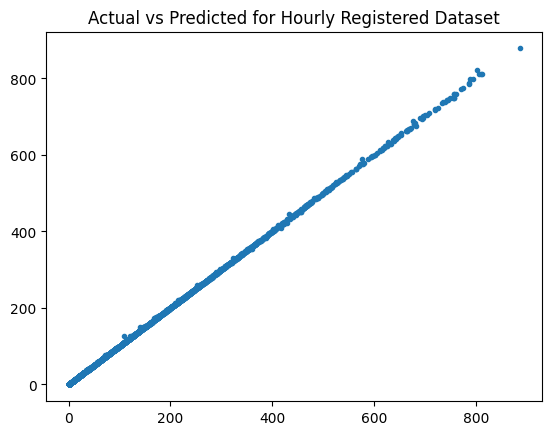

In [ ]:
print(y3_pred.shape)
print(y3_test_hour.shape)
plt.plot(y3_test_hour, y3_pred, '.')
plt.title('Actual vs Predicted for Hourly Registered Dataset')

Text(0.5, 1.0, 'Mean Squared Error for Hourly Dataset')

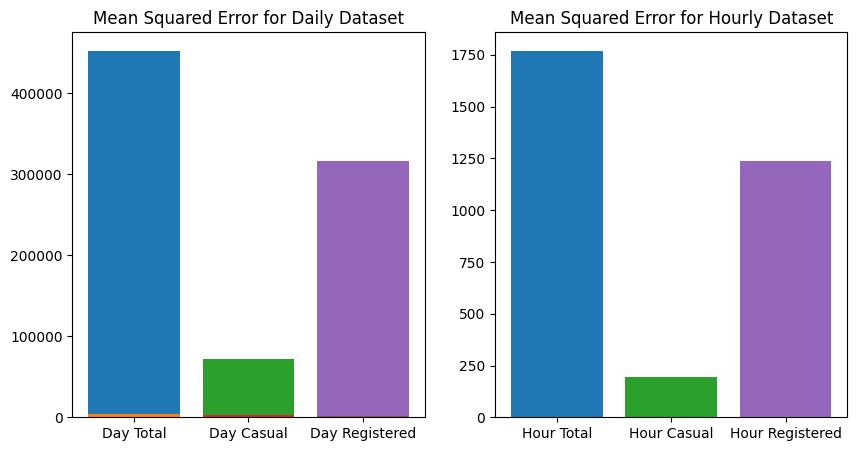

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j, k in zip(labels, MSEs, MSEs_PCA):
  if 'Day' in i:
    ax1.bar(i, j)
    ax1.bar(i, k)
  else:
    ax2.bar(i, j)
    ax2.bar(i, k)

ax1.set_title('Mean Squared Error for Daily Dataset')

ax2.set_title('Mean Squared Error for Hourly Dataset')

Text(0.5, 1.0, 'R2 Score for Hourly Dataset')

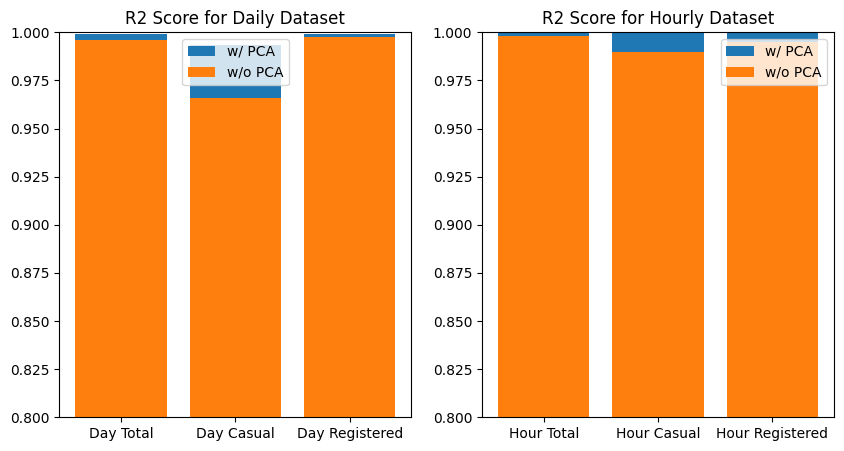

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

for i, j, k in zip(labels, r2s, r2s_PCA):
  if 'Day' in i:
    ax1.bar(i, k, color='tab:blue')
    ax1.bar(i, j, color='tab:orange')

  else:
    ax2.bar(i, k, color='tab:blue')
    ax2.bar(i, j, color='tab:orange')
ax1.set_ylim([0.8,1])
ax2.set_ylim([0.8,1])
ax1.legend(['w/ PCA', 'w/o PCA'])
ax2.legend(['w/ PCA', 'w/o PCA'])
ax1.set_title('R2 Score for Daily Dataset')
ax2.set_title('R2 Score for Hourly Dataset')